```@meta
CurrentModule = CounterfactualExplanations 
```

# MNIST 

In this example we will use algorithmic recourse for MNIST data...

In [121]:
using CounterfactualExplanations, Plots, MLDatasets
using MLDatasets.MNIST: convert2image
using BSON: @save, @load
train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata();

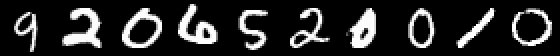

In [122]:
using Images, Random, StatsBase
Random.seed!(1234)
n_samples = 10
samples = train_x[:,:,sample(1:end, n_samples, replace=false)]
mosaicview([convert2image(samples[:,:,i]) for i ∈ 1:n_samples]...,ncol=n_samples)

## Classifier

In [123]:
output_dim = 10
input_dim = prod(size(train_x[:,:,1]))
hidden_dim = 32

32

### Single MLP

In [124]:
using Flux
using Flux: onehotbatch, onecold, DataLoader
y = Flux.onehotbatch(train_y, 0:9)
x = Flux.flatten(train_x)
kw_args = (input_dim=input_dim,n_hidden=hidden_dim,output_dim=output_dim,batch_norm=true)
nn = build_model(;kw_args...)
loss(x, y) = Flux.Losses.logitcrossentropy(nn(x), y)
bs = Int(round(size(x)[2]/10))
data = DataLoader((x,y),batchsize=bs);

In [125]:
using Flux.Optimise: update!, ADAM
using Statistics
opt = ADAM()
epochs = 10
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))
accuracy(data) = mean(map(d -> mean(onecold(softmax(nn(d[1])), 0:9) .== onecold(d[2], 0:9)), data))

if false
  for epoch = 1:epochs
    for d in data
      gs = gradient(params(nn)) do
        l = loss(d...)
      end
      update!(opt, params(nn), gs)
    end
    @info "Epoch " * string(epoch)
    @show accuracy(data)
  end
  @save "data/MNIST.bson" nn
end

In [126]:
using BSON: @load
@load "data/MNIST.bson" nn
testmode!(nn)
test_data = DataLoader((Flux.flatten(test_x),Flux.onehotbatch(test_y, 0:9)), batchsize=bs)
accuracy(test_data)

0.9141666666666667

In [127]:
using CounterfactualExplanations, CounterfactualExplanations.Models
import CounterfactualExplanations.Models: logits, probs # import functions in order to extend

# Step 1)
struct NeuralNetwork <: Models.FittedModel
    nn::Any
end

# Step 2)
logits(𝑴::NeuralNetwork, X::AbstractArray) = 𝑴.nn(X)
probs(𝑴::NeuralNetwork, X::AbstractArray)= softmax(logits(𝑴, X))
𝑴 = NeuralNetwork(nn);

### Deep ensemble

In [128]:
using CounterfactualExplanations: build_ensemble, forward, save_ensemble, load_ensemble
𝓜 = build_ensemble(5;kw=kw_args)
if false
    𝓜, anim = forward(𝓜, data, opt, n_epochs=epochs, plot_loss=false); # fit the ensemble
    save_ensemble(𝓜;root="data/MNIST_ensemble")
end

In [129]:
𝓜 = load_ensemble(;root="data/MNIST_ensemble")
𝓜 = [testmode!(nn) for nn ∈ 𝓜];

In [130]:
# Step 1)
struct FittedEnsemble <: Models.FittedModel
    𝓜::AbstractArray
end

# Step 2)
using Statistics
logits(𝑴::FittedEnsemble, X::AbstractArray) = mean(Flux.stack([nn(X) for nn in 𝑴.𝓜],3), dims=3)
probs(𝑴::FittedEnsemble, X::AbstractArray) = mean(Flux.stack([softmax(nn(X)) for nn in 𝑴.𝓜],3),dims=3)

𝑴_ensemble=FittedEnsemble(𝓜);

### Laplace

In [131]:
# using BayesLaplace
# la = laplace(nn)
# BayesLaplace.fit!(la, data);

In [132]:
# using CounterfactualExplanations, CounterfactualExplanations.Models
# import CounterfactualExplanations.Models: logits, probs # import functions in order to extend

# # Step 1)
# struct LaplaceNeuralNetwork <: Models.FittedModel
#     la::Any
# end

# # Step 2)
# logits(𝑴::LaplaceNeuralNetwork, X::AbstractArray) = log(predict(la, X))
# probs(𝑴::LaplaceNeuralNetwork, X::AbstractArray)= predict(la, X)
# 𝑴 = LaplaceNeuralNetwork(la);

## Recourse

We will use four different approaches to generate recourse: 

1. Wachter for the MLP
2. Greedy approach for the MLP
3. Wachter for the deep ensemble
4. Greedy approach for the deep ensemble (Schut et al.)

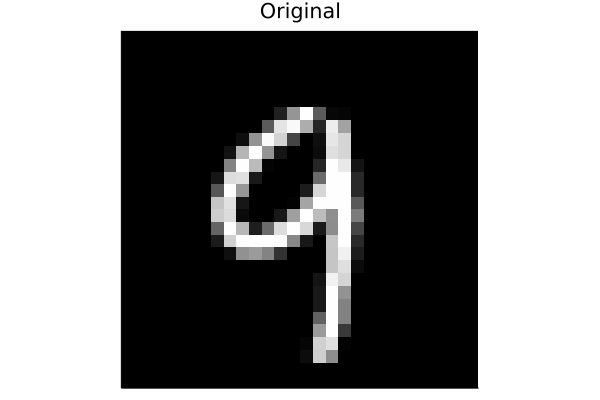

In [133]:
# Randomly selected factual:
Random.seed!(1234);
x̅ = Flux.unsqueeze(x[:,rand(1:size(x)[2])],2)
target = 5
γ = 0.95
img = convert2image(reshape(x̅,Int(sqrt(input_dim)),Int(sqrt(input_dim))))
plt_orig = plot(img, title="Original", axis=nothing)

In [134]:
# Generic - MLP
generator = GenericGenerator(0.1,0.1,1e-5,:logitcrossentropy,nothing)
recourse = generate_counterfactual(generator, x̅, 𝑴, target, γ; feasible_range=(0.0,1.0)) # generate recourse
img = convert2image(reshape(recourse.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim))))
plt_wachter = plot(img, title="MLP - Wachter");

In [135]:
# Greedy - MLP
generator = GreedyGenerator(0.1,15,:logitcrossentropy,nothing)
recourse = generate_counterfactual(generator, x̅, 𝑴, target, γ; feasible_range=(0.0,1.0)) # generate recourse
img = convert2image(reshape(recourse.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim))))
plt_greedy = plot(img, title="MLP - Greedy");

In [136]:
# Generic - Deep Ensemble
generator = GenericGenerator(0.1,0.1,1e-5,:logitcrossentropy,nothing)
recourse = generate_counterfactual(generator, x̅, 𝑴_ensemble, target, γ; feasible_range=(0.0,1.0)) # generate recourse
img = convert2image(reshape(recourse.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim))))
plt_wachter_de = plot(img, title="Ensemble - Wachter");

In [137]:
# Greedy
generator = GreedyGenerator(0.1,15,:logitcrossentropy,nothing)
recourse = generate_counterfactual(generator, x̅, 𝑴_ensemble, target, γ; feasible_range=(0.0,1.0)) # generate recourse
img = convert2image(reshape(recourse.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim))))
plt_greedy_de = plot(img, title="Ensemble - Greedy");

In [138]:
plt_list = [plt_orig, plt_wachter, plt_greedy, plt_wachter_de, plt_greedy_de]
plt = plot(plt_list...,layout=(1,length(plt_list)),axis=nothing, size=(1200,240))
savefig(plt, "www/MNIST_9to4.png")

![](www/MNIST_9to4.png)

### Multiple

In [109]:
using Random

# Single:
function from_digit_to_digit(from, to, generator, model; γ=0.95, x=x, y=y, seed=1234, T=1000)

    Random.seed!(seed)

    candidates = findall(onecold(y,0:9).==from)
    x̅ = Flux.unsqueeze(x[:,rand(candidates)],2)
    target = to + 1
    recourse = generate_counterfactual(generator, x̅, model, target, γ; feasible_range=(0.0,1.0), T=T)

    return recourse
end

# Multiple:
function from_digit_to_digit(from, to, generator::Dict, model::Dict; γ=0.95, x=x, y=y, seed=1234, T=1000)

    Random.seed!(seed)

    candidates = findall(onecold(y,0:9).==from)
    x̅ = Flux.unsqueeze(x[:,rand(candidates)],2)
    target = to + 1
    recourses = Dict()

    for (k_gen,v_gen) ∈ generators
        for (k_mod,v_mod) ∈ models 
            k = k_mod * " - " * k_gen
            recourses[k] = generate_counterfactual(v_gen, x̅, v_mod, target, γ; feasible_range=(0.0,1.0), T=T)
        end
    end

    return recourses
end



from_digit_to_digit (generic function with 2 methods)

In [119]:
generators = Dict("Wachter" => GenericGenerator(0.1,1,1e-5,:logitcrossentropy,nothing),"Greedy" => GreedyGenerator(0.1,15,:logitcrossentropy,nothing))
models = Dict("MLP" => 𝑴, "Ensemble" => 𝑴_ensemble);

In [112]:
from = 3
to = 8
recourses = from_digit_to_digit(from,to,generators,models)
plts =  first(values(recourses)).x̅ |> x -> plot(convert2image(reshape(x,Int(sqrt(input_dim)),Int(sqrt(input_dim)))),title="Original")
plts = vcat(plts, [plot(convert2image(reshape(v.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim)))),title=k) for (k,v) in recourses])
plt = plot(plts...,layout=(1,length(plts)),axis=nothing, size=(1200,240))
savefig(plt, "www/MNIST_$(from)to$(to).png")

In [139]:
from = 7
to = 2
recourses = from_digit_to_digit(from,to,generators,models)
plts =  first(values(recourses)).x̅ |> x -> plot(convert2image(reshape(x,Int(sqrt(input_dim)),Int(sqrt(input_dim)))),title="Original")
plts = vcat(plts, [plot(convert2image(reshape(v.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim)))),title=k) for (k,v) in recourses])
plt = plot(plts...,layout=(1,length(plts)),axis=nothing, size=(1200,240))
savefig(plt, "www/MNIST_$(from)to$(to).png")

In [140]:
from = 1
to = 7
recourses = from_digit_to_digit(from,to,generators,models)
plts =  first(values(recourses)).x̅ |> x -> plot(convert2image(reshape(x,Int(sqrt(input_dim)),Int(sqrt(input_dim)))),title="Original")
plts = vcat(plts, [plot(convert2image(reshape(v.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim)))),title=k) for (k,v) in recourses])
plt = plot(plts...,layout=(1,length(plts)),axis=nothing, size=(1200,240))
savefig(plt, "www/MNIST_$(from)to$(to).png")

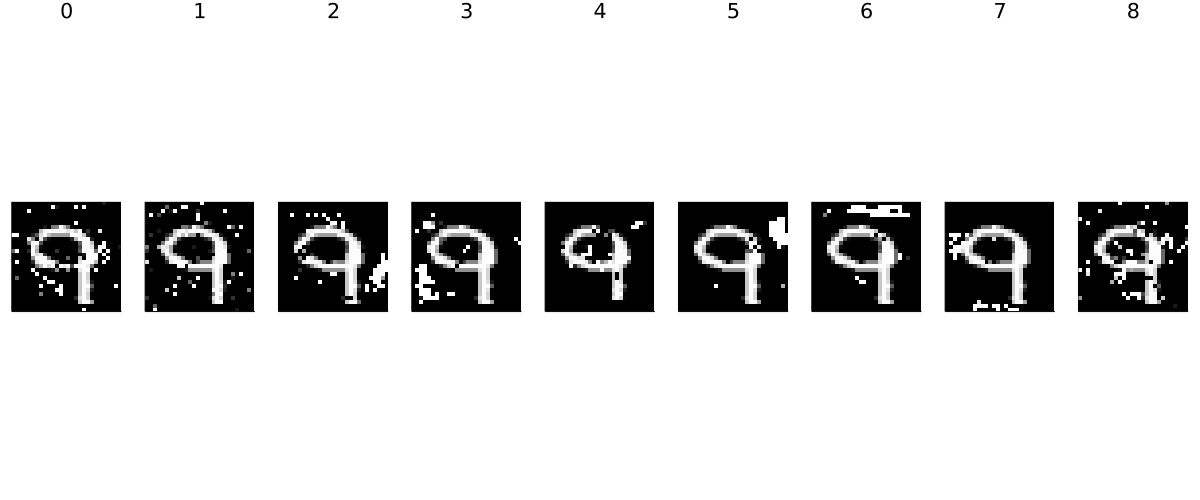

In [97]:
from = 9
recourses = map(d -> from_digit_to_digit(from,d,GreedyGenerator(0.1,15,:logitcrossentropy,nothing),𝑴_ensemble;T=2500),filter(x -> x!=from, Vector(0:9)))
plts = [plot(convert2image(reshape(rec.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim)))),title=rec.target-1) for rec in recourses]
plot(plts...,layout=(1,length(plts)),axis=nothing,size=(1200,500))